<a href="https://colab.research.google.com/github/paolobalasso/YoutubeTrading/blob/main/USETFsDataExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
%%capture
!pip install yfinance
!pip install bt
!pip install PyPortfolioOpt

%matplotlib inline

In [9]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
import bt
import yfinance as yf
import plotly.graph_objects as go


from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, distance
from scipy.spatial.distance import squareform
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline

In [10]:
def drawdown(portfolio_returns: pd.DataFrame) -> pd.Series:
    """
    Calculates the drawdown with a rolling window of 1 year for the given portfolio returns.

    Args:
        portfolio_returns: A pandas dataframe with portfolio returns as values and dates as index.

    Returns:
        A pandas series with the drawdown values for each date in the input dataframe.
    """
    # Calculate the cumulative returns for the portfolio
    cum_returns = (1 + portfolio_returns).cumprod()

    # Calculate the rolling maximum of the cumulative returns over a 1-year window
    rolling_max = cum_returns.rolling(window='365D', min_periods=1).max()

    # Calculate the drawdown as the percentage difference between the rolling maximum and the cumulative returns
    drawdown = (cum_returns - rolling_max) / rolling_max

    # Return the drawdown as a pandas series with the same index as the input dataframe
    return drawdown.min()

def calculate_performance_metrics_price(data):

    returns = data.pct_change().copy()
    histdays = np.isfinite(returns).sum(axis=0).values/252
    annual_returns = (1 + returns).prod() ** (252/np.isfinite(returns).sum(axis=0).values) - 1
    sharpe_ratio = (returns.mean() * 252) / (returns.std() * np.sqrt(252))
    volatility =(returns.std() * np.sqrt(252))
    max_dd = drawdown(returns)
    calmar_ratio = annual_returns / np.abs(max_dd)

    performance_metrics = pd.DataFrame({
        "AnnualizedReturns": annual_returns,
        'historicalYears': histdays,
        'Volatility': volatility,
        "SharpeRatio": sharpe_ratio,
        "MaxDrawdown": max_dd,
        "CalmarRatio": calmar_ratio
    },index=data.columns)

    #(returns + 1).cumprod().plot(label=str(name))

    return performance_metrics

In [11]:
import pandas as pd
url = 'https://github.com/paolobalasso/YoutubeTrading/raw/main/ETFsUS.xlsx'
df=pd.read_excel(url)
df

,Ticker,Total Expense Ratio,MarketCapitalization,ISIN,Broker,Sector,Asset class,Description,Distribution Frequency,Accumulation/Distribution,Sampling
0,XLE,0.12%,19.17,US81369Y5069,Vanguard,Energy,Equity,Energy Select Sector SPDR Fund,Quarterly,Distribution,Physical
1,XLV,0.12%,38.55,US81369Y2090,Vanguard,Healthcare,Equity,Health Care Select Sector SPDR Fund,Quarterly,Distribution,Physical
2,XLP,0.12%,18.68,US81369Y3080,Vanguard,Consumer Defensive,Equity,Consumer Staples Select Sector SPDR Fund,Quarterly,Distribution,Physical
3,XLI,0.12%,12.19,US81369Y7040,Vanguard,Industrials,Equity,Industrial Select Sector SPDR Fund,Quarterly,Distribution,Physical
4,XLU,0.12%,15.35,US81369Y8865,Vanguard,Utilities,Equity,Utilities Select Sector SPDR Fund,Quarterly,Distribution,Physical
5,XLB,0.12%,5.82,US81369Y1001,Vanguard,Basic Materials,Equity,Materials Select Sector SPDR Fund,Quarterly,Distribution,Physical
6,XLF,0.12%,31.54,US81369Y6059,Vanguard,Financial Services,Equity,Financial Select Sector SPDR Fund,Quarterly,Distribution,Physical
7,XLK,0.12%,42.56,US81369Y8030,Vanguard,Technology,Equity,Technology Select Sector SPDR Fund,Quarterly,Distribution,Physical
8,XLRE,0.12%,4.01,US81369Y8600,Vanguard,Real Estate,Equity,Real Estate Select Sector SPDR Fund,Quarterly,Distribution,Physical
9,XLY,0.12%,20.66,US81369Y4070,Vanguard,Consumer Cyclical,Equity,Consumer Discretionary Select Sector SPDR Fund,Quarterly,Distribution,Physical


In [12]:
clusterUS = df.Ticker.to_list()
data = yf.download(clusterUS, start='2010-01-01',end='2024-01-01')['Close']

/tmp/ipython-input-2951098063.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(clusterUS, start='2010-01-01',end='2024-01-01')['Close']
[*********************100%***********************]  27 of 27 completed


/tmp/ipython-input-717060474.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  (yf.download('EMB', start='2010-01-01',end='2024-01-01')['Close'].pct_change()+1).cumprod().plot()
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


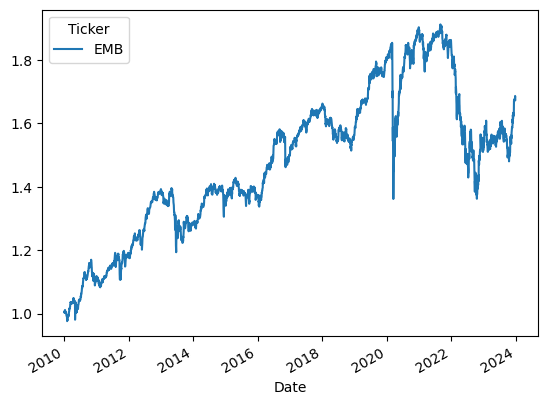

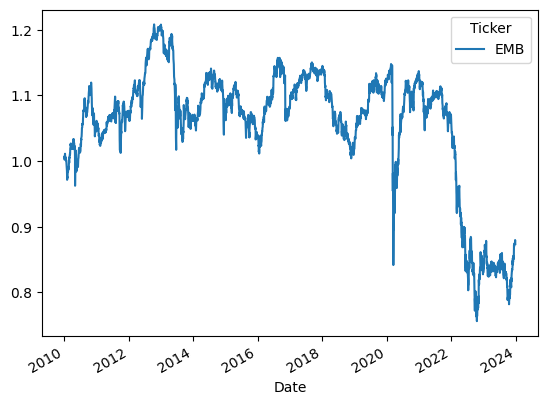

In [13]:
(yf.download('EMB', start='2010-01-01',end='2024-01-01')['Close'].pct_change()+1).cumprod().plot()
(yf.download('EMB', start='2010-01-01',end='2024-01-01',  auto_adjust=False)['Close'].pct_change()+1).cumprod().plot()
plt.show()


In [16]:
# Calculate the 1-year returns for each column
datacorrw = data.copy().loc['2018-01-01':]
datacorrw.columns = df.sort_values('Ticker').Sector
correlation_matrix = datacorrw.dropna(axis=1, how='all').pct_change().corr(method='pearson')
corr_matrix = correlation_matrix#.abs()
corr_ETF_matrix = corr_matrix.dropna(how="all",axis=1).dropna(how="all",axis=0).replace(np.nan,0)

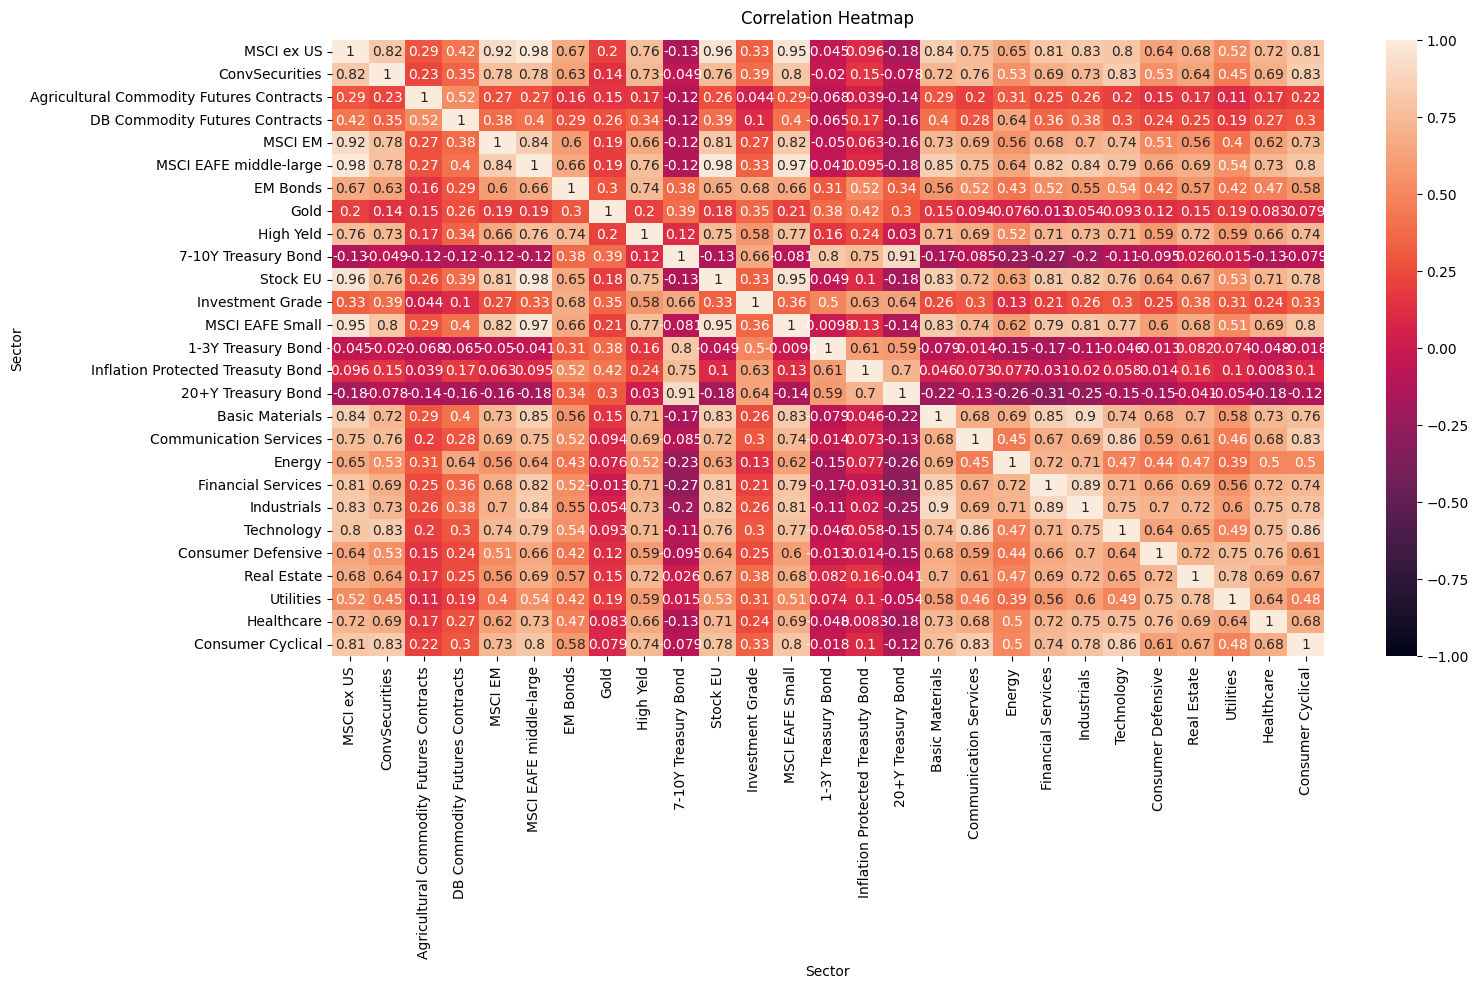

In [17]:
import seaborn as sns

plt.figure(figsize=(16, 8))

heatmap = sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
correlation_matrix

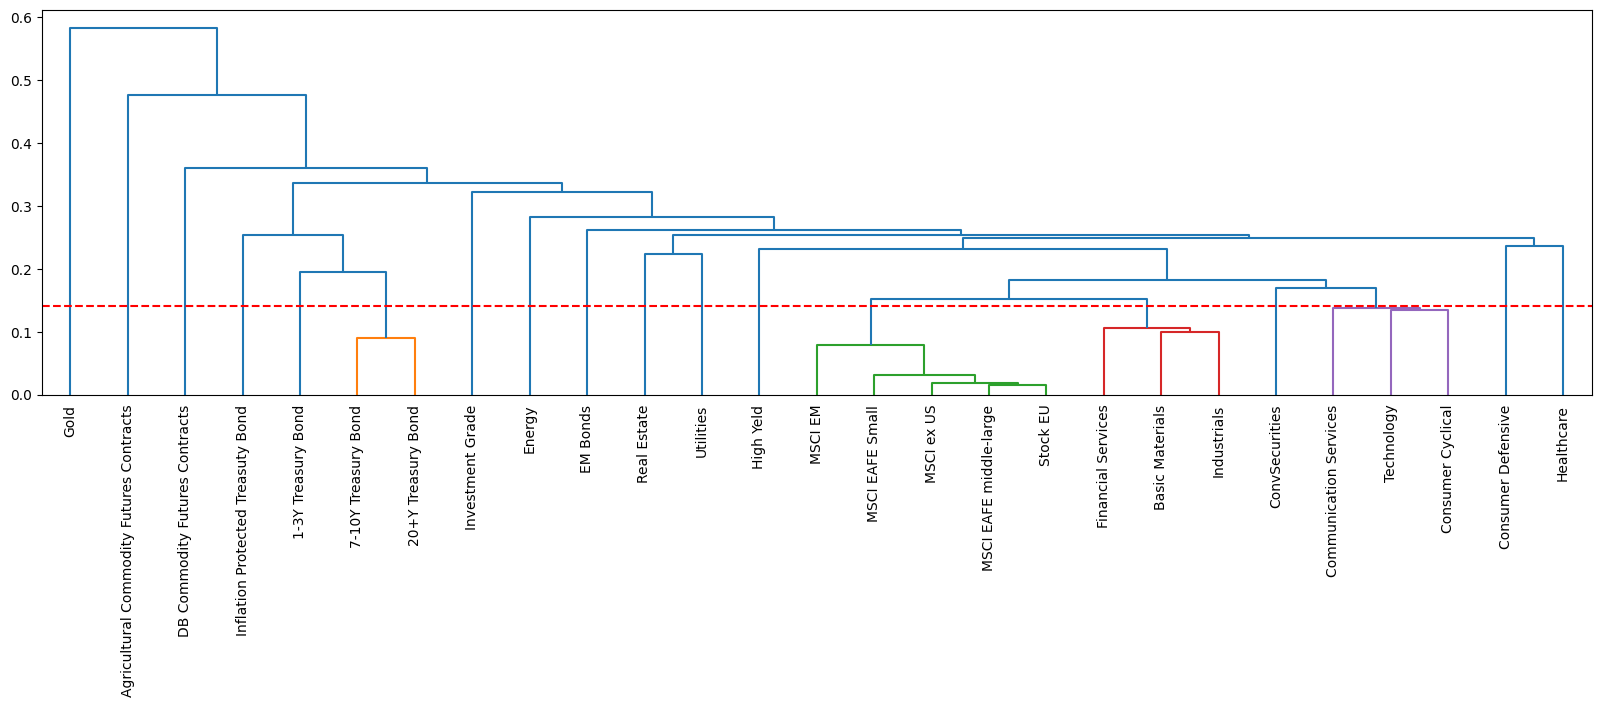

In [18]:

#### hierarchical dendogram correlation
distance_threshold = .14

plt.figure(figsize=(20,5))
Z = linkage(squareform(1-abs(corr_ETF_matrix)), 'single')

dendrogram(Z, labels=corr_ETF_matrix.columns, orientation='top',
           leaf_rotation=90,leaf_font_size=10,color_threshold=distance_threshold)
plt.axhline(y=distance_threshold, color='r', linestyle='--')


#clustercorr = AgglomerativeClustering(distance_threshold=distance_threshold, affinity='euclidean', linkage='single',n_clusters=None)
#clusters = clustercorr.fit_predict(squareform(1-abs(corr_ETF_matrix)))

clusters = fcluster(Z, distance_threshold, criterion='distance')


/tmp/ipython-input-1819984825.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  selected_etfs_df = pd.concat([selected_etfs_df,to_append], ignore_index=True)


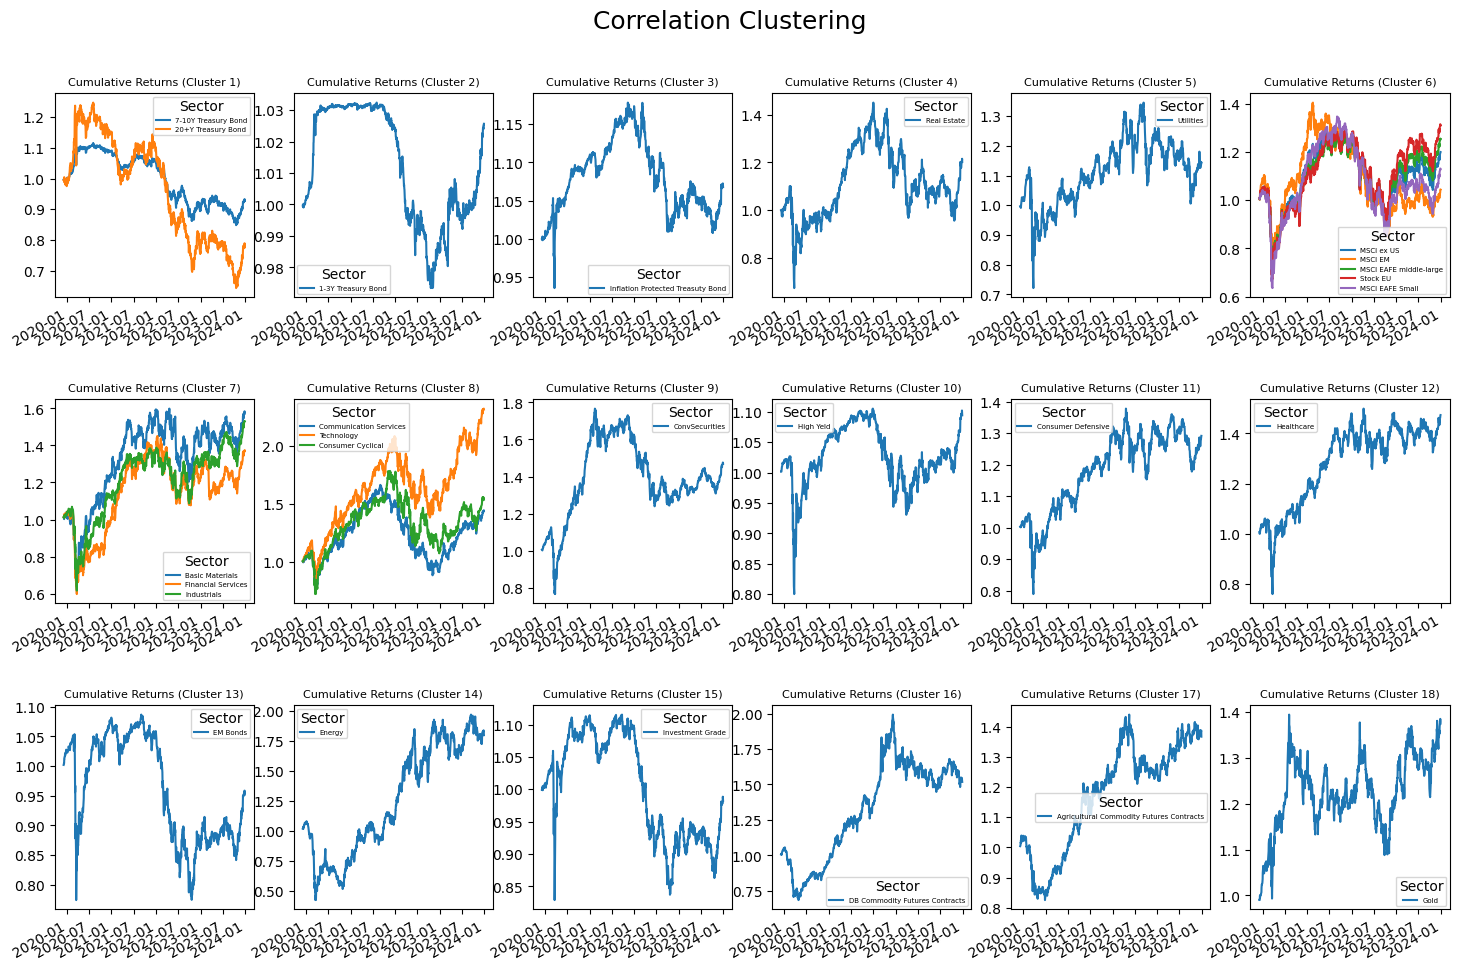

In [19]:
selected_etfs_df = pd.DataFrame(columns=['stock', 'cluster','avg_return'])

fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(18, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Correlation Clustering", fontsize=18, y=0.95)
plt.rc('legend', fontsize=5,loc='lower right')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)



for  cluster, ax in zip(set(clusters),axs.ravel()):
    # Select the columns in the current cluster
    cluster_columns = corr_ETF_matrix.columns[clusters == cluster]
    # append info to the dataframe
    returns = datacorrw[cluster_columns].iloc[-256*4:].pct_change().add(1).cumprod().iloc[-1]-1

    to_append = pd.DataFrame({'stock':cluster_columns.tolist(), 'cluster': cluster.tolist(),'avg_return': returns})
    #selected_etfs_df = selected_etfs_df.append(to_append, ignore_index=True)
    selected_etfs_df = pd.concat([selected_etfs_df,to_append], ignore_index=True)

    # Create a figure
    #fig, ax = plt.subplots()
    # Plot the cumulative returns for each column in the cluster
    datacorrw[cluster_columns].iloc[-256*4:].pct_change().add(1).cumprod().plot(ax=ax)
    # Add a title to the plot
    ax.set_title('Cumulative Returns (Cluster {})'.format(cluster), fontsize=8)
    #ax.get_legend().remove()
    ax.set_xlabel("")


# Show the plot
plt.show()

# Create a new column with 1s in the positions with the maximum value by group and 0s in the other positions
max_index = selected_etfs_df.groupby('cluster')['avg_return'].idxmax()
selected_etfs_df['idmax'] = [1 if i in max_index.values else 0 for i in selected_etfs_df.index]

In [20]:
selected_etfs = selected_etfs_df.loc[selected_etfs_df.idmax == 1]
selected_etfs

,stock,cluster,avg_return,idmax
0,7-10Y Treasury Bond,1,-0.072674,1
2,1-3Y Treasury Bond,2,0.025634,1
3,Inflation Protected Treasuty Bond,3,0.067680,1
4,Real Estate,4,0.202079,1
5,Utilities,5,0.144319,1
9,Stock EU,6,0.309306,1
11,Basic Materials,7,0.571790,1
15,Technology,8,1.312061,1
17,ConvSecurities,9,0.469033,1
18,High Yeld,10,0.094134,1


In [21]:
out1 = calculate_performance_metrics_price(data)
out1.index = df.sort_values('Ticker').Sector
out1.loc[selected_etfs.stock].sort_values('AnnualizedReturns',ascending=False)

,AnnualizedReturns,historicalYears,Volatility,SharpeRatio,MaxDrawdown,CalmarRatio
Sector,,,,,,
Technology,0.180127,13.972222,0.212255,0.886886,-0.335591,0.536746
Healthcare,0.129440,13.972222,0.164011,0.824474,-0.284043,0.455706
Consumer Defensive,0.102937,13.972222,0.139427,0.772673,-0.245123,0.419940
Basic Materials,0.091820,13.972222,0.212895,0.519422,-0.371439,0.247201
ConvSecurities,0.091225,13.972222,0.133424,0.721512,-0.320583,0.284561
Utilities,0.090018,13.972222,0.177301,0.574917,-0.360668,0.249589
Real Estate,0.071676,8.214286,0.213840,0.431478,-0.388247,0.184614
Energy,0.060057,13.972222,0.279986,0.349207,-0.629852,0.095351
Stock EU,0.050153,13.972222,0.207066,0.340552,-0.363560,0.137951


In [22]:
yearly_returns = data.resample('Y').last().pct_change()
yearly_returns.columns = df.sort_values('Ticker').Sector.values
yearly_returns = yearly_returns[selected_etfs.stock]
cumulative_returns = yearly_returns
#cumulative_returns.columns = np.flip(df.sort_values('Ticker').Sector.values)
#cumulative_returns = cumulative_returns[selected_etfs.stock]

fig = go.Figure(data=go.Heatmap(z=cumulative_returns.T.values*100,
                                 x=cumulative_returns.index.year,
                                 y=cumulative_returns.columns,#,
                                 colorscale=[(0, 'red'), (0.37, 'white'), (1, 'green')],
                                 reversescale=False,
                                 texttemplate='%{z:.1f}%',
                                 hovertemplate='ticker: %{y} <br> Year: %{x}%  <br> Ret YoY: %{z:.1f}%'
                                 ))

fig.update_layout(title="Returns",
                  xaxis_title="Year",
                  yaxis_title="Ticker",
                  coloraxis_colorbar=dict(title='Percentage Returns', tickformat=".1%"))

/tmp/ipython-input-4001114121.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_returns = data.resample('Y').last().pct_change()


In [23]:
import plotly.express as px

# Create DataFrame with ETF data
df.plot = out1.loc[selected_etfs.stock].merge(df[['Sector','Asset class','MarketCapitalization','Ticker']].set_index('Sector'),how="left",left_index=True,right_index=True).reset_index().round(4)

# Create scatterplot
fig = px.scatter(df.plot, x='Volatility', y='AnnualizedReturns', size='MarketCapitalization', hover_name='Sector',color='SharpeRatio',
                 title='Equity (Bubble size = ETF cap. B Dollars)', text='Sector', facet_col="Asset class",width=1700, height=600)

fig.update_layout(font=dict(size=8))
fig.update_traces(textposition='middle center')
fig.update_xaxes(range=[0, 0.3])
fig.update_yaxes(range=[-0.02, 0.18])

fig.show()
